# Random Forest Regression Model Training
Testing the training of a simple St Ebbes RF model.

In [1]:
# Python library imports
#------------------------
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import sys
from scipy import stats
#from sklearn.datasets import make_regression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import ExtraTreesRegressor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pickle
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import pytz

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
#----------------
data_home = './oxaria/processed/'
rf_home = './oxaria/processed/models/methods_paper/'
pngs = './oxaria/pngs/
aurn = './oxaria/processed/aurn/'

In [2]:
# Sensor data for colocated device at St Ebbes
#----------------------------------------------
sebbes_train_s15 = pd.read_feather(data_home + 'batch_1_jan20_feb21/sebbes_train_536_s15_ratified.ftr').set_index(
    'rec').sort_index()

# Convert all float64 cols to float32
cols = sebbes_train_s15.select_dtypes(np.float64).columns 
sebbes_train_s15[cols] = sebbes_train_s15[cols].astype(np.float32)


In [3]:
# Function to generate the remaining feature required by the correction model
# -----------------------------------------------------------------------------

def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=1)
    tmpdf1.columns = ['pc15_' + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=2)
    tmpdf2.columns = ['pc30_' + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = df.merge(tmpdf1, left_index=True, right_index=True,
                  how='left').merge(tmpdf2,
                                    left_index=True,
                                    right_index=True,
                                    how='left').set_index(['tag', 'rec'])
    return df


def rushhour(df):
    # calc integer flags for hour of observation
    df['hour'] = df.index.get_level_values(1).hour
    # and day of week
    df['day'] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[(df.index.get_level_values(1).time >= dt.time(7, 30, 0)) &
           (df.index.get_level_values(1).time >= dt.time(9, 30, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 1
    df.loc[(df.index.get_level_values(1).time >= dt.time(16, 0, 0)) &
           (df.index.get_level_values(1).time >= dt.time(18, 0, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 2
    df['rushhour'] = np.where(df['rushhour'] >= 1, df['rushhour'],
                              0).astype(np.int32)
    return df

In [4]:
# Apply feature generation functions to St Ebbes training
#---------------------------------------------------------
tmp_list = []
for tag, dat in sebbes_train_s15.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
sebbes_train_s15_1 = pd.concat(tmp_list)


In [5]:
# Constraining training to Jun to Nov, verification to Dec
# --------------------------------------------------------

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
jan = dt.datetime(2021, 1, 1, 0, 0, 0, tzinfo=pytz.utc)

df = sebbes_train_s15_1.reset_index('tag')
train_jun2nov = df.query('@jun < index <= @dec')

# Keep the interesting cols only, baseline & intermediate dfs
# confuse the training quite a bit, make sure to drop them
# ------------------------------------------------------------
train_df = train_jun2nov.loc[:, [
    'val.no2.wev',
    'val.no2.aev',
    'val.no2.wec',
    'val.sht.hmd_g',
    'val.sht.tmp_g',
    'no2_ppb_s',
    'no2_ppb_h',
    'val.no2.cnc_1_c1',
    'pc15_val.no2.wev',
    'pc15_val.no2.aev',
    'pc15_val.no2.wec',
    'pc15_val.sht.hmd_g',
    'pc15_val.sht.tmp_g',
    'pc15_val.no2.cnc_1_c1',
    'pc30_val.no2.wev',
    'pc30_val.no2.cnc',
    'pc30_val.no2.aev',
    'pc30_val.no2.wec',
    'pc30_val.sht.hmd_g',
    'pc30_val.sht.tmp_g',
    'pc30_val.no2.cnc_1_c1',
    'hour',
    'day',
    'rushhour'
]]

# Drop weirdness in some columns
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16325 entries, 2020-06-05 00:45:00+00:00 to 2020-12-01 00:00:00+00:00
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   val.no2.wev            16325 non-null  float32
 1   val.no2.aev            16325 non-null  float32
 2   val.no2.wec            16325 non-null  float32
 3   val.sht.hmd_g          16325 non-null  float32
 4   val.sht.tmp_g          16325 non-null  float32
 5   no2_ppb_s              16325 non-null  float32
 6   no2_ppb_h              16325 non-null  float32
 7   val.no2.cnc_1_c1       16325 non-null  float32
 8   pc15_val.no2.wev       16325 non-null  float32
 9   pc15_val.no2.aev       16325 non-null  float32
 10  pc15_val.no2.wec       16325 non-null  float32
 11  pc15_val.sht.hmd_g     16325 non-null  float32
 12  pc15_val.sht.tmp_g     16325 non-null  float32
 13  pc15_val.no2.cnc_1_c1  16325 non-null  float32
 14  pc30_va

In [6]:
# Define the training dataset. In this 1st cut using the full St Ebbes timeseries Jun-Nov
# ------------------------------------------------------------------------------------------

# Set training & target variables
X = train_df.drop(columns=[
    'no2_ppb_s','no2_ppb_h'
])  # remove target variable (i.e. no2) from training set.

y = train_df['no2_ppb_s']  # define target variable (i.e. no2).

# Split into training & validation (test) datasets for both dependent & independent variables
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)


In [7]:
# Define a function to test model performance based on a range of max. no, of leaf node sizes
#---------------------------------------------------------------------------------------------
# The following function estimates mean absolute error as a metric for model
# accuracy.The number of trees used is set to 100 (i.e. n_estimators). 500 trees have also been tested but
# without any imporvement in accuracy so 100 is used to reduce training times.


def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):

    # Define the model
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes,
                                  random_state=1,
                                  n_estimators=100,
                                  n_jobs=-1)

    # Create a v simple pipeline that imputes missing input values before fitting the model to them
    #-----------------------------------------------------------------------------------------------
    my_pipeline = Pipeline(steps=[('preprocessor',
                                   SimpleImputer()), ('model', model)])

    # Calculate a metric variable using the cross_val_score function
    #----------------------------------------------------------------
    # The block below performs a cross validation excersise. For a given model configuration, it splits the
    # training set in 5 subsets and carries out a training sequence with the mean absolute error as a metric
    # of performance.
    # An avergae of those 5 MAE is then returned (see Figure below 'Validation' label).
    # This procedure ensures a robust training sequence as it removes the chance of
    # selecting a validation set that is very similar to the testing subset.
    #
    # Fit 5 random subsets of train_x & train_y to the pipeline RFR model & calc mean absolute error
    # multiply by -1 since sklearn calculates *negative* MAE
    metric = -1 * cross_val_score(
        my_pipeline, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')

    # Train the model
    my_pipeline.fit(train_X, train_y)

    # Predict dependent variable using validation & training subsets of independent variables
    preds_val = my_pipeline.predict(val_X)
    preds_tr = my_pipeline.predict(train_X)

    # MAE calculation for training and validation data
    mae_ver = mean_absolute_error(val_y, preds_val)
    mae_tr = mean_absolute_error(train_y, preds_tr)

    # Bring it all together in outputs
    return (mae_ver, mae_tr, metric.mean())


In [8]:
# Calculate model performance using MAE finction
#------------------------------------------------

# Initialise vars with range of nodes to test
mini = 50
maxi = 5000
step = 100

candidate_max_leaf_nodes = np.arange(mini, maxi, step).tolist()

# Loop using dict comprehension to find the ideal tree size from number of nodes tested.
# The following line calls the get_mae function above for
# every value of nodes defined in candiate_max_leaf_nodes.
scores = {
    leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y)
    for leaf_size in candidate_max_leaf_nodes
}
best_tree_size = min(scores, key=scores.get)


In [9]:
# Print leaf results
#--------------------
print(f'The best leaf node size between {mini} and {maxi} is:')
print(best_tree_size)
display(scores)


The best leaf node size between 50 and 5000 is:
4750


{50: (1.6657968206855402, 1.578031821692916, 1.6737893261976802),
 150: (1.472436190551413, 1.2777812247570737, 1.4868356647704106),
 250: (1.3861387851635585, 1.1206445412681867, 1.4087917022505994),
 350: (1.3391753222714666, 1.0163784455911258, 1.3663085242735227),
 450: (1.3055579794187426, 0.93632325861627, 1.3373631630174463),
 550: (1.2803552135012968, 0.8706194767150957, 1.3157774610417508),
 650: (1.262645759136603, 0.815482643689934, 1.2996166809642624),
 750: (1.247850003252494, 0.769143406062456, 1.2878793519454426),
 850: (1.2360991805595394, 0.7292300718650981, 1.2790371263273617),
 950: (1.2270750266511599, 0.6951784508867631, 1.2721549377402825),
 1050: (1.2195670994663983, 0.666121781594833, 1.2663444689639256),
 1150: (1.2146631342936918, 0.6403034486626649, 1.2621199068309854),
 1250: (1.2101438230950614, 0.617840349502724, 1.2590105636389346),
 1350: (1.2052648531189563, 0.5978298901606641, 1.2559826250539792),
 1450: (1.2023659434127092, 0.5804583661455464, 1.25363

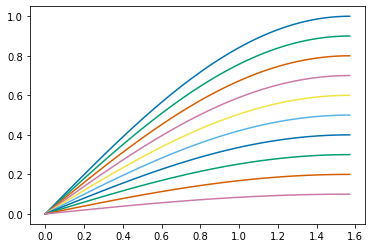

In [10]:
import matplotlib.style as style 
style.use('seaborn-colorblind')

x = np.linspace(0,0.5*np.pi)
ys = np.ones((10,50)) * np.sin(x)
ys = np.array([ys[i,] * np.linspace(1,0.1,10)[i] for i in range(10)])

fig, ax = plt.subplots()
#ax.set_prop_cycle(color=['red','orange','yellow','green','blue','purple'])
ax.plot(x, ys.T)

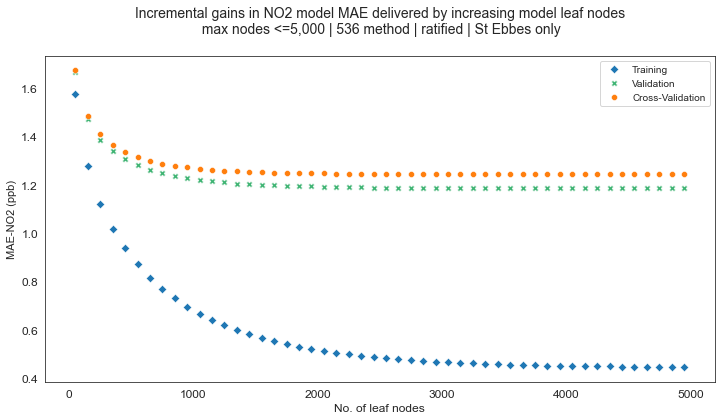

In [11]:
# Plot training & X validation results
#-------------------------------------
import matplotlib.style as style 
style.use('seaborn-colorblind')

test=pd.DataFrame(scores)
plt.figure(figsize=(12,6))
sns.set_style("white", {'axes.grid' : False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'

sns.scatterplot(x=test.columns,y=test.iloc[1], label='Training', marker='D', color='tab:blue')
sns.scatterplot(x=test.columns,y=test.iloc[0], label='Validation', marker='X', color='mediumseagreen')
sns.scatterplot(x=test.columns,y=test.iloc[2], label='Cross-Validation', color='tab:orange')

plt.ylabel('MAE-NO2 (ppb)',fontsize=11)
plt.xlabel('No. of leaf nodes',fontsize=12)
plt.title('Incremental gains in NO2 model MAE delivered by increasing model leaf nodes\n \
max nodes <=5,000 | 536 method | ratified | St Ebbes only\n', fontsize=14)


# Save figure if needed
plt.savefig('xval_results_no2_mln5000_e100_sebbes_536_ratified_cb_mar_final.png', dpi=300)
plt.show()


In [12]:
# Redefine the model using best tree size & number
#--------------------------------------------------
model = RandomForestRegressor(max_leaf_nodes=3500,
                              random_state=1,
                              n_estimators=100,
                              n_jobs=-1)

# fit the model
model.fit(train_X, train_y)
model_prediction = model.predict(val_X)


# Validation results

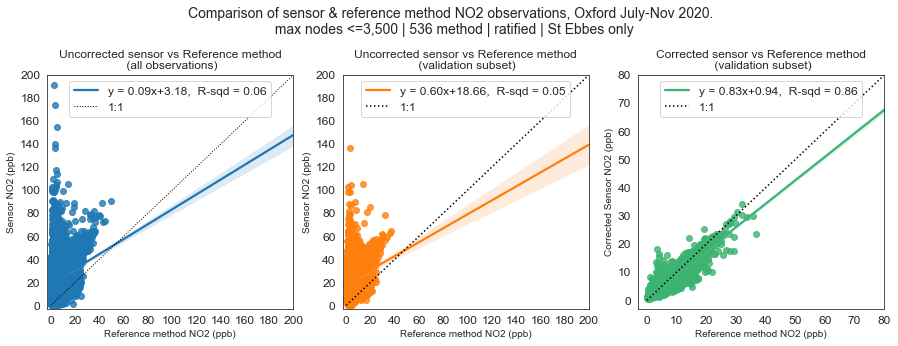

In [13]:
# Plot storyboard of model validation
#-------------------------------------

sns.set_style("white", {'axes.grid' : False})


fig, axes = plt.subplots(1, 3, figsize=(15, 4.3))
fig.suptitle('Comparison of sensor & reference method NO2 observations, Oxford July-Nov 2020. \n \
max nodes <=3,500 | 536 method | ratified | St Ebbes only\n'                           , \
             y=1.1, \
             fontsize=14)

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

xlim = [0, 200]
axes[0].set_xlim(xlim)

# Get regression stats - sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    train_df['val.no2.cnc_1_c1'], train_df['no2_ppb_s'])
# Plot it
sns.regplot(x=train_df['no2_ppb_s'],
            y=train_df['val.no2.cnc_1_c1'],
            color='tab:blue', # steel blue
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[0],
            truncate=False)
axes[0].set(xlabel='Reference method NO2 (ppb)',\
            ylabel='Sensor NO2 (ppb)',\
            title='Uncorrected sensor vs Reference method\n (all observations)',
            xlim=(-3,200),
            ylim=(-3,200),
            xticks=(np.arange(0,220,20)),
            yticks=(np.arange(0,220,20)))

one = [0, 100, 200]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1
            },
            scatter_kws={'s': 0},
            ax=axes[0],ci=None)

axes[1].set_xlim(xlim)

# Recalc regression stats - uncorrected validation subset sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, val_X['val.no2.cnc_1_c1'])
# Plot it
sns.regplot(x=val_y,
            y=val_X['val.no2.cnc_1_c1'],
            color='tab:orange', # brown / orange
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[1],
            truncate=False)
axes[1].set(
    xlabel='Reference method NO2 (ppb)',
    ylabel='Sensor NO2 (ppb)',
    title='Uncorrected sensor vs Reference method\n (validation subset)',
    xlim=(-3, 200),
    ylim=(-3, 200),
    xticks=(np.arange(0, 220, 20)),
    yticks=(np.arange(0, 220, 20)))

sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1.5
            },
            scatter_kws={'s': 0},
            ax=axes[1],ci=None)

axes[2].set_xlim(0, 100)

# Recalc regression stats - corrected validation subset sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
sns.regplot(x=val_y,
            y=model_prediction,
            color='mediumseagreen',  # jade green
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[2],
            truncate=False)
axes[2].set(xlabel='Reference method NO2 (ppb)',
            ylabel='Corrected Sensor NO2 (ppb)',
            title='Corrected sensor vs Reference method\n (validation subset)',
            xlim=(-3, 80),
            ylim=(-3, 80),
            xticks=(np.arange(0, 85, 10)),
            yticks=(np.arange(0, 85, 10)))

one = [0, 100, 200]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1.5
            },
            scatter_kws={'s': 0},
            ax=axes[2],ci=None)

axes[0].legend(loc="upper center", fontsize=12)
axes[1].legend(loc="upper center", fontsize=12)
axes[2].legend(loc="upper center", fontsize=12)

##Save figure if needed.
fig.savefig('training_results_no2_mln3500_e100_sebbes_356_ratified_cb_mar_final.png',
            dpi=300)


In [14]:
sns.color_palette(palette='colorblind')[:]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

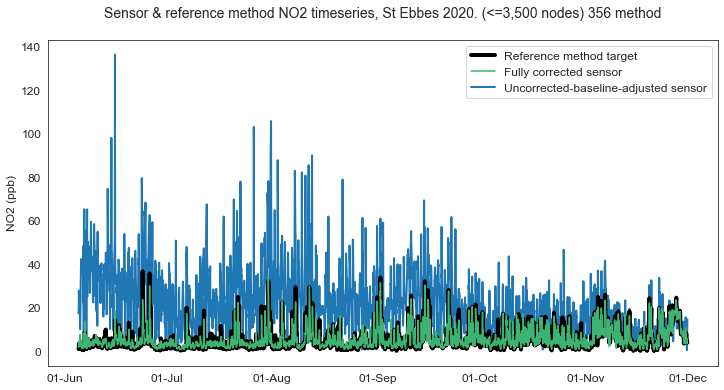

In [15]:
# Create a time series before & after, Jun to Nov
#------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

#sns.set_style("white", {'axes.grid' : False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

# Model prediction
model_prediction = model.predict(val_X)

#Plot results
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=list(val_y.index),
                   y=val_y,
                   label='Reference method target',
                   color='k',
                   lw=4, zorder=2)
ax1 = sns.lineplot(x=list(val_y.index),
                   y=model_prediction,
                   label='Fully corrected sensor',
                   color='mediumseagreen', zorder=3)
ax1 = sns.lineplot(x=list(val_y.index),
                   y=list(val_X['val.no2.cnc_1_c1']),
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:blue', zorder=1, ls='-', lw=2)
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(myFmt)
#plt.ylim((-5, 80))
ax1.set_title('Sensor & reference method NO2 timeseries, St Ebbes 2020. (<=3,500 nodes) 356 method\n', fontsize=14)

plt.ylabel('NO2 (ppb)', fontsize=12)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.legend(loc='upper right',fontsize=12)

plt.savefig('validation_results_no2_mln3500_e100_sebbes1_356_ratified_cb_mar_final.png', dpi=300)
plt.show()

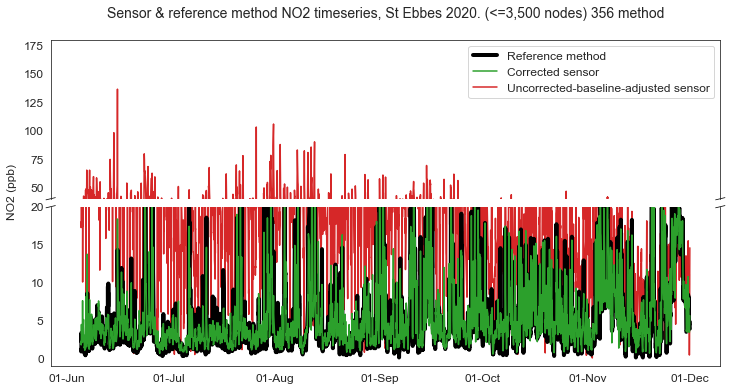

In [16]:
# Plotting the verification results using December 2020 data - split
#--------------------------------------------------------------------
sns.set_style("white", {'axes.grid': False})

myFmt = mdates.DateFormatter('%d-%b')

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'


f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(x=list(val_y.index),
             y=val_y,
             label='Reference method',
             color='k',
             lw=4,
             zorder=2,
             ax=ax)
sns.lineplot(x=list(val_y.index),
             y=model_prediction,
             label='Corrected sensor',
             color='tab:green',
             zorder=3,
             ax=ax)
sns.lineplot(x=list(val_y.index),
             y=list(val_X['val.no2.cnc_1_c1']),
             label='Uncorrected-baseline-adjusted sensor',
             color='tab:red',
             zorder=1,
             ax=ax)

sns.lineplot(x=list(val_y.index), y=val_y, color='k', lw=4, zorder=2, ax=ax2)
sns.lineplot(x=list(val_y.index),
             y=model_prediction,
             color='tab:green',
             zorder=3,
             ax=ax2)
sns.lineplot(x=list(val_y.index),
             y=list(val_X['val.no2.cnc_1_c1']),
             color='tab:red',
             zorder=1,
             ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(40, 180)  # outliers only
ax2.set_ylim(-1, 20)  # most of the data
ax.set_yticks=(np.arange(0,25,10))

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('NO2 (ppb)',fontsize=12)
ax.legend(loc='upper right',fontsize=12)
ax.set_title('Sensor & reference method NO2 timeseries, St Ebbes 2020. (<=3,500 nodes) 356 method\n',
             fontsize=14)

#plt.savefig(pngs + 'validation_results_no2_mln3500_e100_sebbes_356_ratified_split.png',
#            dpi=300)
plt.show()

# Parameter importance

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

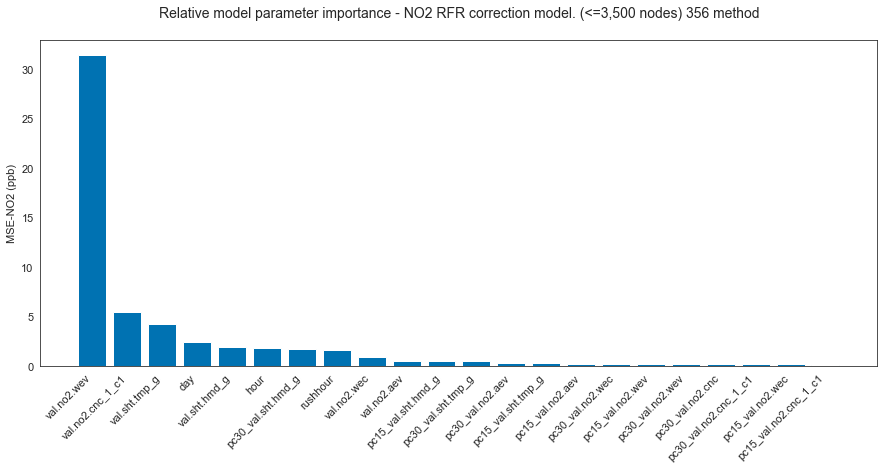

In [17]:
# Permutation importance is a method for determining how important a parameter is by sequentially 
#shuffling model parameters and measuring the effect on model accuracy (MAE in this case) 

# perform permutation importance
results = permutation_importance(model,train_X, train_y, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean
importance=pd.DataFrame(importance,index=train_X.columns, columns=['MSE'])
importance=importance.sort_values(by='MSE',ascending=False)

sns.set_style("white", {'axes.grid' : False})

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
plt.bar(importance.index,importance.MSE);
plt.ylabel('MSE-NO2 (ppb)', fontsize=11)
ax1.xaxis.set_tick_params(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right', fontsize=12)
plt.title('Relative model parameter importance - NO2 RFR correction model. (<=3,500 nodes) 356 method\n', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Save figure if needed
#plt.savefig(pngs+'parameter_importance_no2_mln3500_e100_sebbes_356_ratified.png', dpi=300)



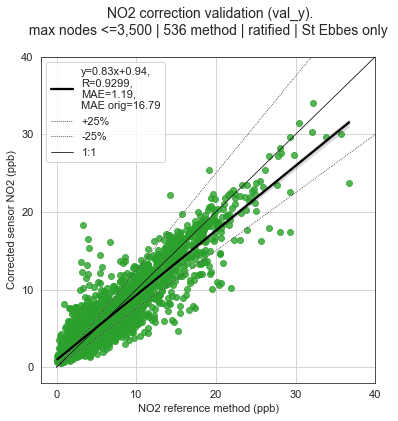

In [18]:
# Plot regression analysis of corrected verification sensor obs vs AURN
#-----------------------------------------------------------------------
sns.set_style("white", {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.250 for i in one]
lower = [i * 0.750 for i in one]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.no2.cnc_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label':
        'y={0:.2f}x+{1:.2f},\nR={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
        format(slope, intercept, r_value, mae_veri, mae_orig),
        'color':
        'k'
    })
ax2 = sns.regplot(x=one,
                  y=upper,
                  color='k',
                  line_kws={
                      'label': '+25%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax3 = sns.regplot(x=one,
                  y=lower,
                  color='k',
                  line_kws={
                      'label': '-25%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax4 = sns.regplot(x=one,
                  y=one,
                  color='k',
                  line_kws={
                      'label': '1:1',
                      'ls': '-',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax1.set_xlim(-2, 40)
ax1.set_ylim(-2, 40)
ax1.set_xticks(np.arange(0, 45, 10))
ax1.set_yticks(np.arange(0, 45, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor NO2 (ppb)', fontsize=11)
plt.xlabel('NO2 reference method (ppb)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax1.set_title(' NO2 correction validation (val_y).\n \
max nodes <=3,500 | 536 method | ratified | St Ebbes only \n', fontsize=14)
plt.show()

# Save figure if needed
#plt.savefig(pngs + 'verification_regression_no2_mln3500_e100_sebbes_356_ratified.png',
#            dpi=300)

## Save model

In [33]:
# Save the model to disk
#------------------------
filename = rf_home + 'RFR_model_no2_mln3500_e100_sebbes_356_ratified_mar_final.sav'
pickle.dump(model, open(filename, 'wb'))


In [34]:
# Read the saved model to avoid all the working above
#-----------------------------------------------------
model = pickle.load(open(rf_home + 'RFR_model_no2_mln3500_e100_sebbes_356_ratified_mar_final.sav', 'rb'))


In [21]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(val_y.index.get_level_values(0), val_y.values, model_prediction))

with open('no2_values_for_cen_calculation_sebbes_3500_356_ratified_mar_final.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'no2_ppb_s', 'val.no2.cnc_1_c2'])
    csv_out.writerows(outfile)
    

In [22]:
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.no2.cnc_1_c1'])

print('MAE in uncorrected verifiction data for Jun to Nov: '+str(mae_orig))
print('MAE in corrected verifiction data for Jun to Nov: '+str(mae_veri))
print('% 0.1f' % mae_orig, '% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for Jun to Nov: 16.793211
MAE in corrected verifiction data for Jun to Nov: 1.1865988635371671
 16.8  1.2


In [23]:
# Constraining training to Jun to Nov, verification to Dec
# --------------------------------------------------------

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
jan = dt.datetime(2021, 1, 1, 0, 0, 0, tzinfo=pytz.utc)

df = sebbes_train_s15_1.reset_index('tag')
val_dec = df.query('@dec < index <= @jan')

# Get dec validation data
# -------------------------
validate_df = val_dec.loc[:, [
    'val.no2.wev',
    'val.no2.aev',
    'val.no2.wec',
    'val.sht.hmd_g',
    'val.sht.tmp_g',
    'no2_ppb_s',
    'no2_ppb_h',
    'val.no2.cnc_1_c1',
    'pc15_val.no2.wev',
    'pc15_val.no2.aev',
    'pc15_val.no2.wec',
    'pc15_val.sht.hmd_g',
    'pc15_val.sht.tmp_g',
    'pc15_val.no2.cnc_1_c1',
    'pc30_val.no2.wev',
    'pc30_val.no2.cnc',
    'pc30_val.no2.aev',
    'pc30_val.no2.wec',
    'pc30_val.sht.hmd_g',
    'pc30_val.sht.tmp_g',
    'pc30_val.no2.cnc_1_c1',
    'hour',
    'day',
    'rushhour'
]]

# Drop weirdness in some columns
validate_df = validate_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)


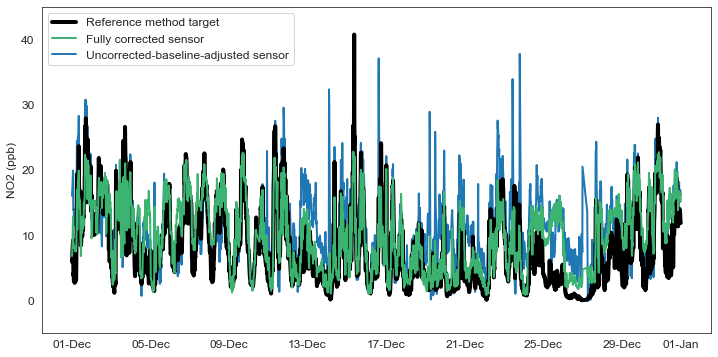

In [24]:
# Plotting the verification results using December 2020 data
#------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

df0 = validate_df.loc[:,'no2_ppb_s']
df1 = validate_df.drop(columns=['no2_ppb_s', 'no2_ppb_h'])

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=list(df0.index),
                   y=list(df0.values),
                   label='Reference method target',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index,
                   y=model_prediction,
                   label='Fully corrected sensor',
                   color='mediumseagreen',
                   zorder=3,
                  lw=2)
ax1 = sns.lineplot(x=df1.index,
                   y=df1['val.no2.cnc_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:blue',
                   lw=2,
                   zorder=1)
#ax1.xaxis.set_major_locator()
ax1.xaxis.set_major_formatter(myFmt)
plt.ylim((-5, 45))
plt.ylabel('NO2 (ppb)', fontsize=12)
plt.xlabel('')

plt.legend(fontsize=12,loc='upper left')
plt.savefig('verification_results_no2_mln3500_sebbes_e100_356_ratified_dec_cb_mar_final.png', dpi=300)
plt.show()

In [26]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(df0.index.get_level_values(0).values, df0.values, model_prediction))

with open('no2_values_for_cen_calculation_sebbes_3500_356_ratified_dec_mar_final.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'no2_ppb_s', 'val.no2.cnc_1_c2'])
    csv_out.writerows(outfile)
    

mae_veri = mean_absolute_error(df0.values, model_prediction)
mae_orig = mean_absolute_error(df0.values, df1['val.no2.cnc_1_c1'])

print('MAE in uncorrected verifiction datafor December: '+str(mae_orig))
print('MAE in corrected verifiction data for December: '+str(mae_veri))
print('% 0.1f' % mae_orig,'% 0.1f' % mae_veri)


MAE in uncorrected verifiction datafor December: 4.1422477
MAE in corrected verifiction data for December: 2.62418608930717
 4.1  2.6


In [27]:
# Doing verification with Dec unseen data with extra uniform backround time slots
# ---------------------------------------------------------------------------------

# Sensor data for colocated device at St Ebbes
# ----------------------------------------------
sebbes_train_s15 = sebbes_train_s15.reset_index().set_index(
    ['tag', 'rec']).sort_index()
sebbes_train_s15_2021 = pd.read_feather(folder + 'q12021/sebbes_train_536_s15+2021.ftr').set_index(
    ['tag', 'rec']).sort_index()

# Convert all float64 cols to float32
cols = sebbes_train_s15_2021.select_dtypes(np.float64).columns
sebbes_train_s15_2021[cols] = sebbes_train_s15_2021[cols].astype(np.float32)

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
apr = dt.datetime(2021, 4, 1, 0, 0, 0, tzinfo=pytz.utc)

# Constraining sebbes verification to Dec 2020
# ---------------------------------------------

df = pd.concat([sebbes_train_s15, sebbes_train_s15_2021])  # .reset_index()

# add features
# --------------
tmp_list = []
for tag, dat in df.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
df = pd.concat(tmp_list).sort_index()

val_dec_sebbes = df.query('@dec <= rec < @apr')

# Get dec validation data
# -------------------------
validate_df = val_dec_sebbes.loc[:, [
    'val.no2.wev',
    'val.no2.aev',
    'val.no2.wec',
    'val.sht.hmd_g',
    'val.sht.tmp_g',
    'no2_ppb_s',
    'no2_ppb_h',
    'val.no2.cnc_1_c1',
    'pc15_val.no2.wev',
    'pc15_val.no2.aev',
    'pc15_val.no2.wec',
    'pc15_val.sht.hmd_g',
    'pc15_val.sht.tmp_g',
    'pc15_val.no2.cnc_1_c1',
    'pc30_val.no2.wev',
    'pc30_val.no2.cnc',
    'pc30_val.no2.aev',
    'pc30_val.no2.wec',
    'pc30_val.sht.hmd_g',
    'pc30_val.sht.tmp_g',
    'pc30_val.no2.cnc_1_c1',
    'hour',
    'day',
    'rushhour'
]]

# Drop weirdness in some columns
validate_df = validate_df.replace([np.inf, -np.inf],
                                  np.nan).dropna(axis=0).sort_index()
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49483 entries, ('scs-bgx-538', Timestamp('2020-12-01 00:00:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-03-31 23:45:00+0000', tz='UTC'))
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   val.no2.wev            49483 non-null  float32
 1   val.no2.aev            49483 non-null  float32
 2   val.no2.wec            49483 non-null  float32
 3   val.sht.hmd_g          49483 non-null  float32
 4   val.sht.tmp_g          49483 non-null  float32
 5   no2_ppb_s              49483 non-null  float32
 6   no2_ppb_h              49483 non-null  float32
 7   val.no2.cnc_1_c1       49483 non-null  float32
 8   pc15_val.no2.wev       49483 non-null  float32
 9   pc15_val.no2.aev       49483 non-null  float32
 10  pc15_val.no2.wec       49483 non-null  float32
 11  pc15_val.sht.hmd_g     49483 non-null  float32
 12  pc15_val.sht.tmp_g     49483 non-nul

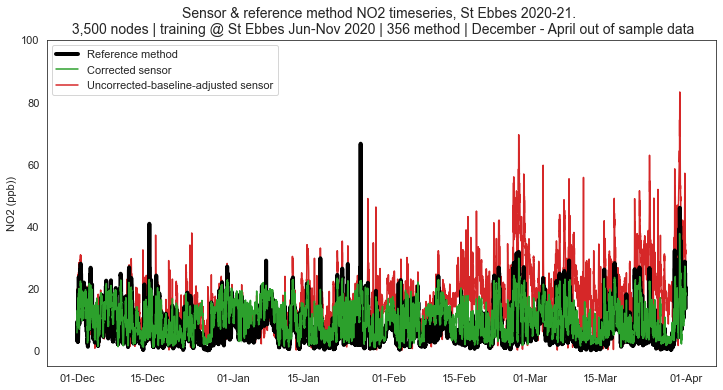

In [28]:
# Plotting the verification results using December 2020 data 
#------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

df0 = validate_df.loc[:,'no2_ppb_s']
df1 = validate_df.drop(columns=['no2_ppb_s','no2_ppb_h'])

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0.values,
                   label='Reference method',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green',
                   zorder=3)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.no2.cnc_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red',
                   zorder=1)
#ax1.xaxis.set_major_locator()
ax1.xaxis.set_major_formatter(myFmt)
plt.ylim((-5, 100))
plt.ylabel('NO2 (ppb))', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11,loc='upper left')
ax1.set_title('Sensor & reference method NO2 timeseries, St Ebbes 2020-21. \n \
3,500 nodes | training @ St Ebbes Jun-Nov 2020 | 356 method | December - April out of sample data', fontsize=14)
plt.savefig(pngs + 'verification_results_no2_mln3500_sebbes_e100_converging_536_ratified_apr.png', dpi=300)
plt.show()